# Plotting FFT data
### This notebook contains the following:

    1. One function (load_interval) for loading FFT WT data for a given component
    2. One function (plot_2d_bins) for plotting the RMS bin values in 2D
    3. Two function (print3d_with_poly_collection & print3d_with_axes3d) for plotting frequency (x), amplitide (z) and interval (y) in 3D. Only the first one is used.

In [50]:
!which python
import sys
sys.executable

/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/bin/python


'/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/bin/python'

In [51]:
import numpy as np
import wt_data
import ff_transform
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

In [52]:
import sys, os

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src


 ## __load_interval__ loads all the intervals for one turbine (GEARBOX)
This feature has the name 'GbxHssRr;0,0102;m/s2'.

In [53]:
'''
wt_name is either 'WTG01', 'WTG02', 'WTG03', or 'WTG04'

'''
def load_interval(wt_name, BINS,SENSOR_NAME, load_minimal=False):
    wt_instance = wt_data.load_instance(wt_name, load_minimal=False)
    print(f"This is the amount of intervals: {len(wt_instance.ten_second_intervals)}")
    
    y = []
    x = []
    z = []
    
    avg_powers = [] # Stores the average power for each interval
    
    
    two_d_plot = d = [[] for x in range(BINS)]
    
    i = 0
    for interval in wt_instance.ten_second_intervals:
        ts = interval.sensor_df['TimeStamp']  # Have this as the y-axis to see how the RMS/frequencies develop
        try:
            vibration_signal = interval.sensor_df[SENSOR_NAME]
        except:
            continue


        y_repeated = np.repeat(i, 50)  # Repeat this y value n times to use as the y value for the corresponding x (frequency) and z (magnitude)
        y.append(y_repeated)
        i = i + 1

        comp_type = 'gearbox'
        
        
        
        avg_power = interval.op_df["PwrAvg;kW"][0]
        rot_data = interval.high_speed_rot_data
        fast = ff_transform.FastFourierTransform( vibration_signal, ts, comp_type)
        fft, time, centroid, rms, rms_bins, bin_freq = fast.fft_transform_time(rot_data,
                                                                               avg_power,
                                                                               calc_rms_for_bins=True,
                                                                     plot=False,
                                                                     bins=BINS,
                                                                     plot_vertical_lines=False)
        N = fast.s.size
        T = fast.t[1] - fast.t[0]
        f = np.linspace(0, 1 / T, N, )
        f = f[:N // 2]

        z.append(rms_bins)
        x.append(bin_freq)
        avg_powers.append(interval.op_df['PwrAvg;kW'][0])
        
        for i, rms_amplitude in enumerate(rms_bins):
            two_d_plot[i].append(rms_amplitude)


        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x,y,z, two_d_plot, avg_powers

## 2D plotting function

In [54]:
# Plotting 2d bins
def plot_2d_bins(bin_values):
    num_intervals = len(bin_values[0])
    #fig = plt.figure()
    
    # fig, axs = plt.subplots(10,5, figsize=(15,20), facecolor='w', edgecolor='k',dpi=200)    

    # fig.subplots_adjust(hspace = .5, wspace=.001)
    # plt.subplots_adjust(top=0.96)

    # axs = axs.ravel()
    
    x_news = []
    y_news = []
    #plt.suptitle('RMS development for each interval')
    for j, binn in enumerate(bin_values):
        
        # Fitting a polynomial to each bin plot: 
        # get x and y vectors
        y = binn
        x = np.arange(0,len(binn))
        
        # calculate polynomial
        z = np.polyfit(x, y, 10)
        f = np.poly1d(z)

        # calculate new x's and y's
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
        
        # axs[j].plot(binn) # Plotting the RMS
        # axs[j].plot(x_new, y_new,color='orange') # Plotting the fitted line on top of that
        # axs[j].autoscale(enable=True, axis='y', tight=None)
        # axs[j].set_title(f"Bin {j+1}. Freq. range:")
        # axs[j].margins(0)
        x_news.append(x_new)
        y_news.append(y_new)
    
    # fig.tight_layout() 
    # plt.show()

    
    fig = plt.figure(figsize = (15,10))
    # plt.style.use('seaborn')    
    for i,x in enumerate(x_news):
        plt.plot(x,y_news[i], label=1)
        x_post = i %  50
        plt.ylim(top = np.max(y_news) + 0.2)



        
        #plt.text(x[x_post], y_news[i][1], 'sample {i}'.format(i=i), fontsize = 14)

    plt.legend(fontsize=10)
        # plt.legend(np.arange(1,51))
    # labelLines(plt.gca().get_lines(),align=True,fontsize=14)

    plt.margins(0)
    fig.tight_layout() 

    plt.show()

## Creating a 3d plot using PolyCollection

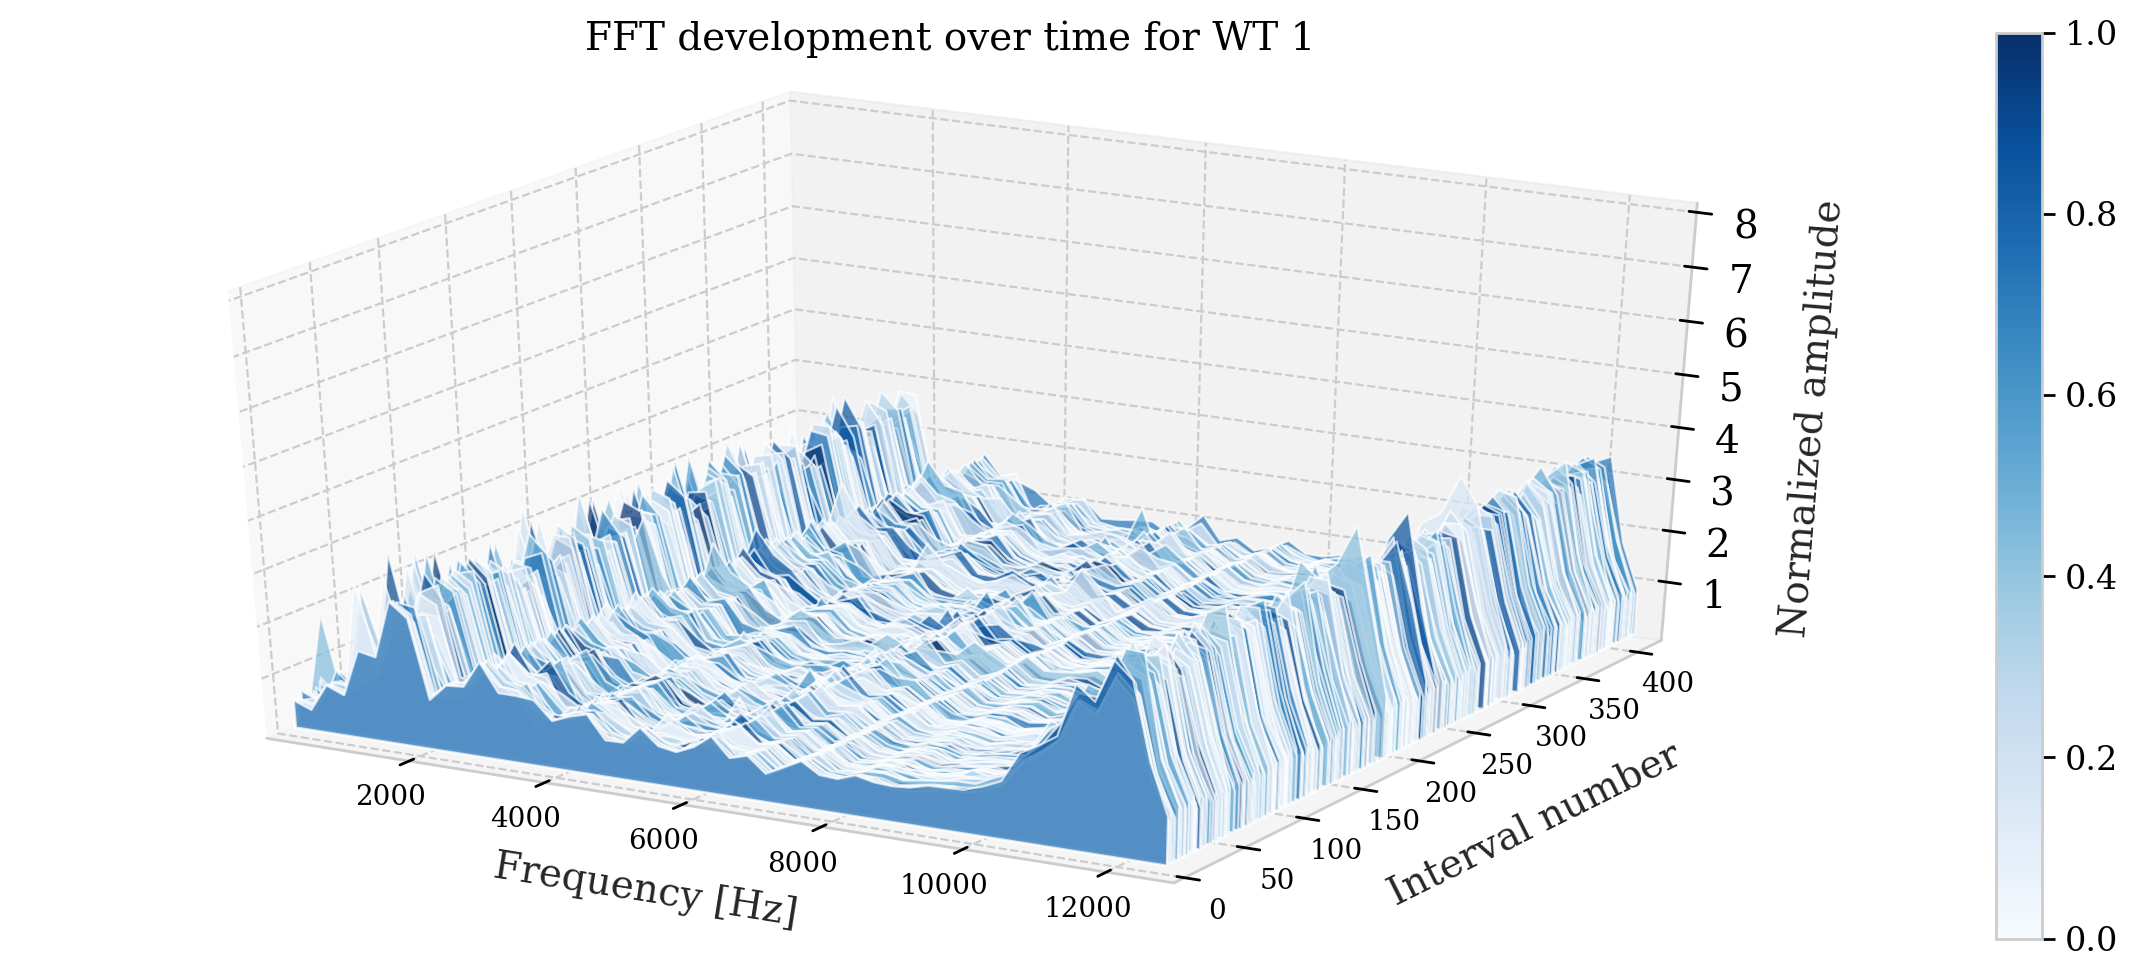

In [131]:
'''
    Create a 3d-plot using the poly collection module from matplotlib.
'''
from matplotlib import cm, pyplot as plt

def print3d_with_poly_collection(wt_number,x,y,z,color_alt,average_powers, cm_style='Blues',filter = False):

    if filter == True:
        z = filter_RMS_spikes(x,y,z)
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"FFT development over time for WT {wt_number}",pad=20)

    
    # Get the numpy arrays on the correct shape
    freq_data = x.T
    amp_data = z.T
    rad_data = np.linspace(0,amp_data.shape[1],amp_data.shape[1])
    
    verts = []

    for irad in range(len(rad_data)):
        # I'm adding a zero amplitude at the beginning and the end to get a nice
        # flat bottom on the polygons
        xs = np.concatenate([[freq_data[0,irad]], freq_data[:,irad], [freq_data[-1,irad]]])
        ys = np.concatenate([[0],amp_data[:,irad],[0]])
        verts.append(list(zip(xs, ys)))

    # Colors:
    
    if color_alt == 'color_alt4':
        cmap = cm.get_cmap(cm_style)
        # inferno
        norm = [float(i)/sum(average_powers) for i in average_powers]
        col = [cmap(x) for x in np.random.rand(amp_data.shape[1])]
        poly = PolyCollection(verts, facecolors = col)

    else:
        
        poly = PolyCollection(verts)


    # facecolors = col
    # facecolors = ['r', 'g', 'c', 'y','r', 'g', 'c', 'y','r', 'g', 'c']
    poly.set_alpha(0.7)
    # poly.set_cmap('blues')

    # The zdir keyword makes it plot the "z" vertex dimension (radius)
    # along the y axis. The zs keyword sets each polygon at the
    # correct radius value.
    ax.add_collection3d(poly, zs=rad_data, zdir='y')

    ax.set_xlim3d(freq_data.min(), freq_data.max())
    
    ax.set_xlabel('Frequency [Hz]',labelpad=10)
    ax.set_ylim3d(rad_data.min(), rad_data.max())
    ax.set_ylabel('Interval number',labelpad=10)
    # ax.set_zlim3d(amp_data.min(), amp_data.max())
    ax.set_zlim3d(amp_data.min(), 8)
    ax.set_zlabel('Normalized amplitude')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cb = plt.colorbar(sm);
    ticklabs = cb.ax.get_yticklabels()
    cb.ax.tick_params(labelsize=12) 
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.tick_params(axis='both', which='major', pad=1)
    # plt.zticks(fontsize=10)


    plt.show()

In [56]:
# Remove spikes that seem unnaturally large (by inspection). From the 3D plots,
# one can see that the spikes show up "randomly". They are therefore filtered away
def filter_RMS_spikes(x,y,z):
    for i, array in enumerate(z):
        for j, rms_val in enumerate(array):
            if rms_val > 10:
                # divide it by 2
                z[i][j] = rms_val/2
                print(f"Previous value: {rms_val}. New value: {z[i][j]}")
                
    return z

## Creating surface 3d plots with axes3d

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def print3d_with_axes3d(x,y,z,cm_style='Blues'):
    X = np.array(x)
    Y = np.array(y)
    Z = np.array(z)
    
    X = X.T
    Y = Y.T
    Z = Z.T
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    cmap = cm.get_cmap(cm_style)
    surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                           linewidth=0, antialiased=False)
    plt.title("Frequency development over intervals for WT")
    plt.show()

## Running the functions
Loading up the WT's

**WTG01**

In [58]:
WIND_TURBINE = 'WTG01'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,two_d_plot_tw01, avg_powers_wt01 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt01.shape)
print(rms_amplitudes_wt01.shape)
print(interval_nums_wt01.shape)



Loading WTG01...
Loaded WTG01
This is the amount of intervals: 415
(414, 50)
(414, 50)
(414, 50)


**WTG02**

In [5]:
WIND_TURBINE = 'WTG02'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,two_d_plot_tw02,avg_powers_wt02 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)

print(freqs_wt02.shape)
print(rms_amplitudes_wt02.shape)
print(interval_nums_wt02.shape)



Loading WTG02...
Loaded WTG02
This is the amount of intervals: 426


/Users/stianismar/Dropbox/gitProsjekter/master-thesis/src/data_processing/ff_transform.py:203: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  amp = fft_modulus_norm[filter_indexes]


(426, 50)
(426, 50)
(426, 50)


**WTG03**

In [ ]:
WIND_TURBINE = 'WTG03'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt03, interval_nums_wt03, rms_amplitudes_wt03,two_d_plot_tw03,avg_powers_wt03 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt03.shape)
print(rms_amplitudes_wt03.shape)
print(interval_nums_wt03.shape)


**WTG04**

In [ ]:
WIND_TURBINE = 'WTG04'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt04, interval_nums_wt04, rms_amplitudes_wt04,two_d_plot_tw04,avg_powers_wt04 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt04.shape)
print(rms_amplitudes_wt04.shape)
print(interval_nums_wt04.shape)


### Playing around with different colours

In [ ]:
'''print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt2','Blues' )
print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt2','bone' )

print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt2','YlGnBu' )
print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt2','Accent' )
print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt1' )
print3d_with_poly_collection( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,'color_alt3' )
'''

In [ ]:
'''print3d_with_axes3d( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01)
print3d_with_axes3d( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01, cm_style='viridis')

print3d_with_axes3d( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01, cm_style='Paired')

print3d_with_axes3d( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01, cm_style='ocean')
print3d_with_axes3d( freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01, cm_style='gist_heat')
'''

In [ ]:
'''print3d_with_poly_collection( freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,'color_alt2','Blues' )
# print3d_with_poly_collection( freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,'color_alt3' )
'''

In [ ]:
'''
print3d_with_poly_collection( freqs_wt03, interval_nums_wt03, rms_amplitudes_wt03,'color_alt2','Blues' )
# print3d_with_poly_collection( freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,'color_alt3' )
'''

In [ ]:
'''
print3d_with_poly_collection( freqs_wt04, interval_nums_wt04, rms_amplitudes_wt04,'color_alt2','Blues' )
print3d_with_poly_collection( freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,'color_alt3' )
'''

# Plotting 2D: Study the development of the bins

In [ ]:
from labellines import labelLine, labelLines

print('plot_2d_bins(two_d_plot_tw01)')
plot_2d_bins(two_d_plot_tw01)
print(" ")
print('plot_2d_bins(two_d_plot_tw02)')
plot_2d_bins(two_d_plot_tw02)
print(" ")
print('plot_2d_bins(two_d_plot_tw03)')
plot_2d_bins(two_d_plot_tw03)
print(" ")
print('plot_2d_bins(two_d_plot_tw04)')
plot_2d_bins(two_d_plot_tw04)

# Plotting 3D: Comparison

In [ ]:
print3d_with_poly_collection("1",
                             freqs_wt01,
                             interval_nums_wt01, 
                             rms_amplitudes_wt01,
                             'color_alt4',
                             avg_powers_wt01,
                             'Blues',
                             False)

print3d_with_poly_collection("2",
                             freqs_wt02,
                             interval_nums_wt02, 
                             rms_amplitudes_wt02,
                             'color_alt4',
                             avg_powers_wt02,
                             'Blues',
                             False)

print3d_with_poly_collection("3",
                             freqs_wt03,
                             interval_nums_wt03, 
                             rms_amplitudes_wt03,
                             'color_alt4',
                             avg_powers_wt03,
                             'Blues',
                             False)

print3d_with_poly_collection("4",
                             freqs_wt04,
                             interval_nums_wt04, 
                             rms_amplitudes_wt04,
                             'color_alt4',
                             avg_powers_wt04,
                             'Blues',
                             False)

In [ ]:
print3d_with_poly_collection("1",
                             freqs_wt01,
                             interval_nums_wt01, 
                             rms_amplitudes_wt01,
                             'color_alt4',
                             avg_powers_wt01,
                             'Blues',
                             True)

print3d_with_poly_collection("2",
                             freqs_wt02,
                             interval_nums_wt02, 
                             rms_amplitudes_wt02,
                             'color_alt4',
                             avg_powers_wt02,
                             'Blues',
                              True)

print3d_with_poly_collection("3",
                             freqs_wt03,
                             interval_nums_wt03, 
                             rms_amplitudes_wt03,
                             'color_alt4',
                             avg_powers_wt03,
                             'Blues',
                              True)

print3d_with_poly_collection("4",
                             freqs_wt04,
                             interval_nums_wt04, 
                             rms_amplitudes_wt04,
                             'color_alt4',
                             avg_powers_wt04,
                             'Blues',
                              True)

# Filtering the data (removing the high spikes > 10)

    - Loop through the bins before plotting, find the ones that have amplitude above 10 and get the index. Remove this from x,y,z arrrays
    - Why does 2 and 3 look so different? Does it have the same resolution etc.?